#  **Colab File for 2D-CNN training for Classification - PyTorch**
Before you start please prepare the following:


1.   Uplaod the dataset as Zip file to GDrive
2.   Upload code files to GDrive



# **Install and Import Required Libraries**
Use 'pip' to install libraries. Put '!' i.e. Exclamation Mark before each command, exclusive to Jupyter Notebooks. Some are already installed by Google Colab and others are required. If the IMPORT statements are present in the python code being run, no need to follow this step.

Install or Update Libraries

In [ ]:
# !pip install torch==1.11.0 torchvision==0.12.0 torchaudio
# !pip install torchvision
# !pip install torchsummary
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install scikit-image
%pip install ipython
%pip install Pillow
%pip install matplotlib
%pip install seaborn
%pip install timm
%pip install opencv-python
%pip install glob2
%pip install glob2

Import Libraries

In [1]:
import cv2
import numpy as np
import timm
import os
import warnings
import torch.nn as nn
import torch
import random
import shutil
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import import_module
from os import path
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch import optim, cuda, tensor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings('ignore', category=FutureWarning)
plt.rcParams['font.size'] = 14

/root/miniconda3/envs/wsl_miniconda_env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Check GPU Status**
Check the available GPU from the Google Server, GPU model and other related information.

**Please MAKE sure that you are using GPU . Go to Runtime>> Change Runtime type  and select GPU**

In [2]:
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))

Is CUDA enabled GPU Available? True
Is GPU Initialized yet? False
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)


# **Import and Prepare Code and Dataset files** 
1- Copy dataset file and codes to your Google Colab instance (Change file names if necessary ), dont have to copy the data files to the content here, as it will be copied in the next code

In [3]:
def copyimagefile(source_path, destination_path, files_list):
    for order in range(1, len(files_list)):
        files = files_list[order]
        shutil.copyfile(os.path.join(source_path, files),
                        os.path.join(destination_path, files))


In [4]:
def create_folds(raw_data_path, num_folds, train_portion, validation_portion=False):
    Class_Names = os.listdir(raw_data_path)
    for i in range(1, num_folds + 1):
        print(f'Creating Fold {i}')
        for ii in tqdm(range(0, len(Class_Names))):
            # Get Train and Test Image Indices Randomly for each Fold
            source_path = f'{raw_data_path}/{Class_Names[ii]}'
            X_Tot = os.listdir(source_path)  # List containing all images
            X_Train_Len = int(len(X_Tot) * train_portion)
            # Randomly formed List containing images for training, can be stratified otherwise
            X_Train = random.sample(X_Tot, (X_Train_Len - 1))
            # List containing images for testing
            X_Test = [x for x in X_Tot if x not in X_Train]
            X_Val = []
            if validation_portion:
                # Size of the Validation Set, subset of the Training Set
                X_Val_Len = int(len(X_Train) * validation_portion)
                X_Val = random.sample(
                    X_Train, (X_Val_Len - 1))  # Validation Set
                # Validation Set is deducted from the Training Set
                X_Train = [x for x in X_Train if x not in X_Val]

            # Make Required Directories after Checking their Existence, sometimes delete old folders and run the code again
            train_dir = f'Data/Train/fold_{i}/{Class_Names[ii]}'
            test_dir = f'Data/Test/fold_{i}/{Class_Names[ii]}'
            val_dir = f'Data/Val/fold_{i}/{Class_Names[ii]}'
            if not os.path.isdir(train_dir):
                os.makedirs(train_dir)  # Train Directory for Fold ii
            if not os.path.isdir(test_dir):
                os.makedirs(test_dir)  # Test Directory for Fold ii
            if (not os.path.isdir(val_dir)) and (validation_portion != False):
                os.makedirs(val_dir)  # Validation Directory for Fold ii

            # Copy Image Files from the Source Folder to the Destination Folder
            copyimagefile(source_path, train_dir, X_Train)
            copyimagefile(source_path, test_dir, X_Test)
            if validation_portion:
                # True if validation set is created independently
                copyimagefile(source_path, val_dir, X_Val)


In [30]:
raw_data_path = 'rawdata'
num_folds = 5
train_portion = 0.8  # test_portion = 1 - train_portion
val_portion = 0.1  # validation data is part of the train set
create_folds(raw_data_path, num_folds, train_portion,
             validation_portion=val_portion)


Creating Fold 1


100%|██████████| 2/2 [01:44<00:00, 52.35s/it]


Creating Fold 2


100%|██████████| 2/2 [00:54<00:00, 27.11s/it]


Creating Fold 3


100%|██████████| 2/2 [01:01<00:00, 30.54s/it]


Creating Fold 4


100%|██████████| 2/2 [01:03<00:00, 31.98s/it]


Creating Fold 5


100%|██████████| 2/2 [01:02<00:00, 31.26s/it]


# **MAIN**



## **Train**

Training Configurations

In [ ]:
%%writefile config_train.py
# CNN train configuration file 
config = {}
config['parentdir'] = ''                      # root directory
config['isPretrained'] = True                         # set to 'True' to use pretrained weights or set to 'False' to train from scratch
config['model_mode'] = 'import_Torch'                   # 'custom_CNN' | 'custom_ONN' | 'import_Torch' | 'import_TIMM'
config['q_order'] = 3                                  # qth order Maclaurin approximation, common values: {1,3,5,7,9}. q=1 is equivalent to conventional CNN
config['ONN'] = False                                  # set to 'True' if you are using ONN
config['input_ch'] = 3                                 # 1 for gray scale x-rays, and 3 for RGB (3channel) x-rays  
config['batch_size'] = 8                               # Batch size, Change to fit hardware, common values: {4,8,16} for 2D datasets
# config['input_mean'] = [0.2936]                      # Dataset mean per channel, b/w [0,1]
# config['input_std'] = [0.1895]                       # Dataset std per channel,  b/w [0,1]
config['input_mean'] = [0.0169,0.0169,0.0169]          # Dataset mean per channel, RGB or RGBA [0,1]
config['input_std'] = [0.1251,0.1251,0.1251]           # Dataset std per channel,  RGB or RGBA [0,1]
config['loss_func'] = 'NLLLoss'                        # 'MSELoss', 'CrossEntropyLoss', etc. (https://pytorch.org/docs/stable/nn.html)
config['optim_fc'] = 'Adam'                            # 'Adam', 'SGD', etc. (https://pytorch.org/docs/stable/optim.html)
config['optim_scheduler'] = 'ReduceLROnPlateau'        # 'ReduceLROnPlateau', etc. (https://pytorch.org/docs/stable/optim.html)
config['final_activation_func'] = 'LogSoftmax'            # 'Sigmoid', 'Softmax', etc. (https://pytorch.org/docs/stable/nn.html)
config['lr'] = 0.0002                                  # learning rate 
config['stop_criteria'] = 'accuracy'                   # Stopping criteria: 'loss' or 'accuracy'
config['n_epochs'] = 100                               # Number of training epochs
config['epochs_patience'] = 10                         # If val loss did not decrease for a number of epochs then decrease learning rate by a factor of lr_factor
config['lr_factor'] = 0.1                              # Learning factor
config['max_epochs_stop'] = 15                         # Maximum number of epochs with no improvement in validation loss for early stopping
config['num_folds'] = 1                                # Number of cross-validation folds
config['Resize_h'] = 512                             # Network input (Image) height
config['Resize_w'] = config['Resize_h']                # Network input (Image) width
config['load_weights'] = False                       # Default: False, comment it out and Specify path of pretrained model weights above to make it True  
# config['load_weights'] = config['parentdir'] + 'Checkpoint_1.pt' # specify path of pretrained model weights or set to False to train from scratch
config['aux_logits'] = False                      # Required for models with auxilliary outputs (e.g., InceptionV3)     
config['model_to_load'] = 'densenet201'                # Choose one of the models specified in config file
config['model_name'] = 'DenseNet201_Stone_Instance_Classification_AS2'  # Choose a unique name for result folder            
config['encoder'] = False                              # Set to 'True' if you retrain Seg. model encoder as a classifer 
config['fold_to_run'] = [5,5]                          # Define as [] to loop through all folds, or specify start and end folds i.e. [3,5] or [5,5]
config['outdir'] = ''


Overwriting config_train.py


Start Training

In [ ]:
%run -m train

## **Test and Evaluate**

Copy the training results back to GDrive to acesss them later


---

Please note:

1.   **Results are going to be lost when you trun off the current section (Close the tab or leave it for more then 90 mins without any activity)** 
2.   **Make sure that "Results" file is not in your directory to avoid overwriting any existing results**

Test Configurations

In [3]:
%%writefile config_test.py
# CNN test configuration file
config = {}
config['parentdir'] = ''  # Root directory
# Set to 'True' if you are using ONN
config['ONN'] = False
# 1 for gray scale x-rays, and 3 for RGB (3channel) x-rays
config['input_ch'] = 3
# Batch size, Change to fit hardware
config['batch_size'] = 4
# Number of cross-validation folds
config['num_folds'] = 1
# Confidence interval (missied cases with probability>=CI will be reported in excel file)
config['CI'] = 0.9
# config['input_mean'] = [0.2936]                     # Dataset mean per channel, b/w [0,1]
# config['input_std'] = [0.1895]                      # Dataset std per channel,  b/w [0,1]
# Dataset mean per channel, RGB or RGBA [0,1]
config['input_mean'] = [0.0169,0.0169,0.0169]
# Dataset std per channel,  RGB or RGBA [0,1]
config['input_std'] = [0.1251,0.1251,0.1251]
# 'MSELoss', 'CrossEntropyLoss', etc. (https://pytorch.org/docs/stable/nn.html)
config['loss_func'] = 'NLLLoss'
# Network input (Image) height
config['Resize_h'] = 512
# Network input (Image) width
config['Resize_w'] = config['Resize_h']
# config['load_weights'] ='/content/gdrive/MyDrive/EthnicData/Results/mobilenet_v2/mobilenet_v2_fold_1.pt'    # specify full path of pretrained model pt file
# Specify path of pretrained model wieghts or set to False to train from scratch
config['load_weights'] = False
# Set to true if you have the labeled test set
config['labeled_Data'] = True
# Required for models with auxilliary outputs (now, only for some custom_CNN models)
config['aux_logits'] = False
# Name of trained model .pt file, same name used in train code
config['model_name'] = 'DenseNet201_Stone_Instance_Classification_AS2'
# Specify a new folder name to save test results
config['new_name'] = 'DenseNet201_Stone_Instance_Classification_AS2'
# Number of steps for inference
config['N_steps'] = 10
# Define as [] to loop through all folds, or specify start and end folds i.e. [3, 5] or [5, 5]
config['fold_to_run'] = [1,5]
# The destination directory for saving the pipeline outputs (models, results, plots, etc.)
config['outdir'] = 'Results'

Overwriting config_test.py


Evaluate the Test set

In [ ]:
%run -m test

## Generate Confusion Matrix for Article

In [11]:
confusion_matrix_raw = np.array([[5195,336],[274,12099]])
confusion_matrix_norm = np.array([[0.94,0.06],[0.02,0.99]])
labels = ['Stone', 'No Stone']
print(confusion_matrix_raw)

[[ 5195   336]
 [  274 12099]]


In [ ]:
shape = confusion_matrix_raw.shape
data = np.asarray(confusion_matrix_raw, dtype=int)
text = np.asarray(confusion_matrix_norm, dtype=float)
annots = (np.asarray(["{0:.2f} ({1:.0f})".format(text, data) for text, data in zip(text.flatten(), data.flatten())])).reshape(shape[0],shape[1])
fig = plt.figure(figsize=(len(labels)*5, len(labels)*4))
sns.heatmap(confusion_matrix_norm, cmap='Blues', annot=annots, fmt='', annot_kws={'fontsize': 28}, xticklabels=labels, yticklabels=labels, vmax=1)
sns.set(font_scale=1.8)
plt.title('Confusion Matrix', fontsize=30)
plt.xlabel("Predicted", fontsize=24)
plt.ylabel("True", fontsize=24)

## Measure Inference Time

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Timing utility
from timeit import default_timer as timer
# Configurations
Total_time = 0.0
N_steps = 1000
# Load Model
model_path = 'Results/DenseNet201_Kidney_Instance_Classification/fold_1/DenseNet201_Kidney_Instance_Classification_fold_1.pt'
checkpoint = torch.load(model_path)
model = checkpoint['model']
model.eval()
model = model.to('cuda')
print(count_parameters(model))
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(mean=[0.0169,0.0169,0.0169],
                                 std=[0.1251,0.1251,0.1251])
preprocess = transforms.Compose([transforms.ToTensor(), normalize])
# Load Sample Image as Input Data
image_path = 'Data/Train/fold_1/No Kidney/wd0036_ps_image_133.png'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
tensor = preprocess(image)  # convert image to tensor
tensor = tensor.unsqueeze(0)  # reshape 4D tensor (N, C, H, W)
tensor = tensor.to(device='cuda')
print(tensor.size())
for i in range(N_steps):
    input_time = timer()
    out = model(tensor) 
    output_time = timer() 
    output_time = output_time - input_time
    Total_time = Total_time + output_time
    del out
print(f'Total Inference Time: {((Total_time*1000)/N_steps):.4} ms')

# **CAM**

Import custom functions

In [25]:
from CAM.imagenet_labels import label2idx, idx2label
from CAM.visualize import visualize, reverse_normalize
from CAM.cam_functions import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
%matplotlib inline


Import and process image

In [43]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(mean=[0.0169,0.0169,0.0169],
                                 std=[0.1251,0.1251,0.1251])
preprocess = transforms.Compose([transforms.ToTensor(), normalize])

torch.Size([1, 3, 512, 512])


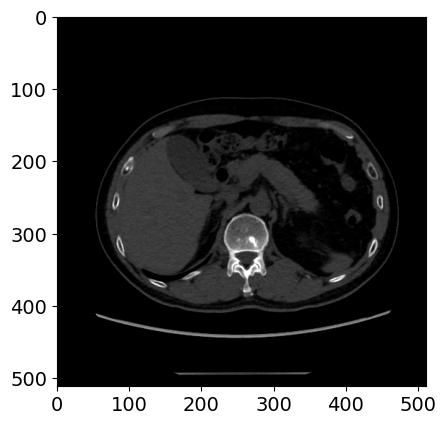

In [44]:
image_path = 'Data/Train/fold_1/No Kidney/wd0036_ps_image_133.png'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
# image = cv2.resize(image, (512,512), interpolation = cv2.INTER_CUBIC)  # Resize image
plt.imshow(image)
tensor = preprocess(image)  # convert image to tensor
tensor = tensor.unsqueeze(0)  # reshape 4D tensor (N, C, H, W)
print(tensor.size())


Import Model and Extract Target Layer

In [ ]:
model_path = 'Results/DenseNet201_Kidney_Instance_Classification/fold_1/DenseNet201_Kidney_Instance_Classification_fold_1.pt'
checkpoint = torch.load(model_path)
model = checkpoint['model']
model.eval()


In [46]:
target_layer = model.features.denseblock4['denselayer32'].conv1
print(target_layer)

Conv2d(1888, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


Create Warapper Model for CAM

In [47]:
# Configuration - Choose CAM Type
# Current Options: 'CAM', 'GradCAM', 'GradCAM++', 'SmoothGradCAM++', 'ScoreCAM
wrapper_model_type = 'ScoreCAM'
tensor = tensor.to(device='cuda')
model = model.to('cuda')


In [48]:
wrapper_model = []
if wrapper_model_type == 'CAM':
    wrapper_model = CAM(model, target_layer)
elif wrapper_model_type == 'GradCAM':
    wrapper_model = GradCAM(model, target_layer)
elif wrapper_model_type == 'GradCAM++':
    wrapper_model = GradCAMpp(model, target_layer)
elif wrapper_model_type == 'SmoothGradCAM++':
    wrapper_model = SmoothGradCAMpp(
        model, target_layer, n_samples=25, stdev_spread=0.15)
elif wrapper_model_type == 'ScoreCAM':
    tensor = tensor.to(device='cuda')
    model = model.to('cuda')
    wrapper_model = ScoreCAM(model, target_layer)


Plot and Save CAM Heatmap

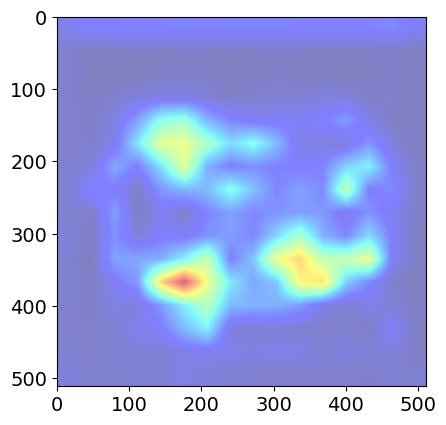

In [49]:
cam, idx = wrapper_model(tensor)
# print(idx2label[idx])
plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')  # Visualize only cam

<Figure size 640x480 with 0 Axes>

(-0.5, 511.5, 511.5, -0.5)

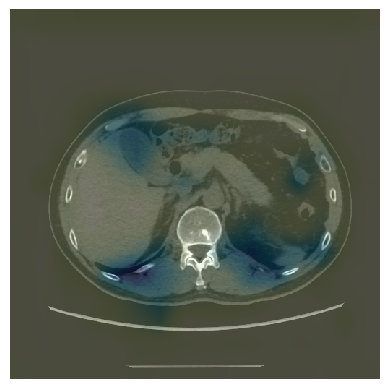

In [50]:
# reverse normalization for display
img_ = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)
cam_ = cam.squeeze().numpy()
heatmap_ = np.moveaxis(np.squeeze(heatmap.cpu().detach().numpy()),0,2)
# super_imposed_img = cv2.addWeighted(cam_, 0.1, img_, 0.9, 0)
plt.figure()
plt.imshow(img_, interpolation='nearest')
plt.imshow(cam_,'YlGnBu',alpha=0.3, interpolation='nearest')
plt.axis('off')
plt.savefig("cam_output.png", bbox_inches='tight', pad_inches = 0)

# **Move Files to and fro GDrive**

## Copy Experiment Results from Virtual Machine or VM (Contents) to a Google Drive Folder

In [ ]:
!cp - av '/content/Results/' '/content/GDrive/MyDrive/'


## Copy Documents from a Google Drive Folder to VM (Contents)

In [ ]:
!cp - av '/content/GDrive/MyDrive/Research/Kidney_AHN_Segmentation/Results' '/content'


## Remove non-empty Directory from the VM

In [ ]:
import shutil
shutil.rmtree('/content/Data')


# **Infinite Loop**

In [ ]:
while True:
    pass
